<a href="https://colab.research.google.com/github/hemanthk97/AHRMS/blob/master/performance_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import numpy as np
import numba
import pandas as pd
import multiprocessing as mp
from functools import lru_cache as cache

from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math

files_path = 'https://raw.githubusercontent.com/yhilpisch/py4fi/master/jupyter36/source/'

# **Loops**

> This section tackles the python loop issue. The task is rather simple: a function shall be written that draws a certian "large" number of random numbers and returns the average of the values. The execution time is of interset, which can be estimated by the magic functions **%time** abd **%timeit**.

## **Python**

In [0]:
def average_py(n):
  s = 0
  for i in range(n):
    s += random.random()
  return s / n

In [0]:
n = 10000000
%time average_py(n)

CPU times: user 1 s, sys: 0 ns, total: 1 s
Wall time: 1.01 s


0.5001989118268079

In [0]:
%timeit average_py(n)

1 loop, best of 3: 969 ms per loop


In [0]:
%time sum([random.random() for _ in range(n)]) / n

CPU times: user 1.23 s, sys: 253 ms, total: 1.48 s
Wall time: 1.48 s


0.4999224227176434

## **NumPy**

> The strength of **NumPy** lies in its vectorization capabilities. Formally loops vanish on the python level; the looping takes place one level deeper based on optimized and compiled routines provided by **NumPy**. The function function `average_np()` make use of this approach.

In [0]:
def average_np(n):
  s = np.random.random(n)
  return s.mean()

In [0]:
%time average_np(n)

CPU times: user 99.1 ms, sys: 1.05 ms, total: 100 ms
Wall time: 101 ms


0.5000075866875175

In [0]:
%timeit average_np(n)

10 loops, best of 3: 97.6 ms per loop


In [0]:
s = np.random.random(n)
s.nbytes

80000000

> The speedup is considerable, reaching almost a factor of 10 or an order of mangnitude. However, the price that must be paid is  significantly higher memory usage. This is due to the fact that **NumPy** attains speed by preallocating data that can be processed in the compiled layer. As a consquence, ther is no way, given this approach, to work with "streamed" data.This increased memory usage might even be prohibitively large depending on the algorithm or problem at hand.

## **Numba**

> **Numba** is a package that allows the *dynamic compiling* of pure python code by the use of LLVM. The application in a simple case, like the one at hand, is surprisingly straightforward and the dynamically complied function `average_nb()` can be called directly from python.

In [0]:
average_nb = numba.jit(average_py) #This creates the Numba function.

In [0]:
%time average_nb(n) # The compiling happens during runtime, leading to some overhead.

CPU times: user 123 ms, sys: 3.93 ms, total: 127 ms
Wall time: 127 ms


0.4999803090041615

In [0]:
%time average_nb(n) # From the second execution (with same input data types), the execution is faster.

CPU times: user 67.3 ms, sys: 1.01 ms, total: 68.3 ms
Wall time: 69.5 ms


0.5000112575640676

In [0]:
%timeit average_nb(n)

10 loops, best of 3: 60.1 ms per loop


> The combination of pure Python with **Numba** beats the **NumPy** version and preserves the memory effiency of the original loop-based implmentation. It is also obvious that the application of **Numba** in such simple cases comes with hardly any programming overhead.

## **Cython**

> **Cython** allows one to *statically compile* python code. However, the application is not as simple as with **Numba** since the code generally needs to be changed the **Cython** function `average_cy1()`, which introduces static type declarations for the used variables.

In [0]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [0]:
%%cython -a
import random
def average_cy1(int n):
  cdef int i
  cdef float s = 0
  for i in range(n):
    s += random.random()
  return s/n

In [0]:
%time average_cy1(n)

CPU times: user 615 ms, sys: 0 ns, total: 615 ms
Wall time: 618 ms


0.5000699162483215

In [0]:
%timeit average_cy1(n)

1 loop, best of 3: 596 ms per loop


> Some speedup is observed, but not even close to that achieved by, for, the ***NumPy** version. A bit more **Cython** optimization is necessary to beat even the **Numba** version.

In [0]:
%%cython
from libc.stdlib cimport rand
cdef extern from 'limits.h':
  int INT_MAX
cdef int i
cdef float rn
for i in range(5):
  rn = rand() / INT_MAX
  print(rn)

0.27777472138404846
0.5539699792861938
0.47739705443382263
0.6288709044456482
0.36478447914123535


In [0]:
%%cython -a
from libc.stdlib cimport rand
cdef extern from 'limits.h':
  int INT_MAX
def average_cy2(int n):
  cdef int i
  cdef float s = 0
  for i in range(n):
    s += rand() / INT_MAX
  return s / n

In [0]:
%time average_cy2(n)

CPU times: user 208 ms, sys: 931 µs, total: 209 ms
Wall time: 209 ms


0.5000576972961426

In [0]:
%timeit average_cy2(n)

1 loop, best of 3: 206 ms per loop


# **Algorithms**

> This section applies the performace-enhancing techniques from the pervious section to some well-know problems and algorithms from mathematics. These alogrithms are regularly used for performance benchmarks.

## **prime numbers**

### **Python**

In [0]:
def is_prime(I):
  if I % 2 == 0 : return False # if the number is even, False is returned immediately
  for i in range(3,int(I**0.5)+1,2): # the loop starts at 3 and goes until square root of I plus 1 with step size 2
    if I % i == 0: return False
  return True

In [0]:
n = int(1e8+3)
n

100000003

In [0]:
%time is_prime(n)

CPU times: user 39 µs, sys: 2 µs, total: 41 µs
Wall time: 44.1 µs


False

In [0]:
p1 = int(1e8+7)
p1

100000007

In [0]:
%time is_prime(p1)

CPU times: user 633 µs, sys: 0 ns, total: 633 µs
Wall time: 641 µs


True

In [0]:
p2 = 100109100129162907 # A larger prime numbers which requires longer execution times.
p2.bit_length()

57

In [0]:
%time is_prime(p2)

CPU times: user 17.6 s, sys: 512 µs, total: 17.6 s
Wall time: 17.7 s


True

### **Numba**

> The loop structure of the algorithm in the function `is_prime()` lends itself well to be being dynamically compiled with **Numba**. The overhead again is minimal but the speedup considerable.

In [0]:
is_prime_numba = numba.jit(is_prime)

In [0]:
%time is_prime_numba(n)

CPU times: user 118 ms, sys: 2.99 ms, total: 121 ms
Wall time: 127 ms


False

In [0]:
%time is_prime_numba(n)

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 12.4 µs


False

In [0]:
%time is_prime_numba(p1)

CPU times: user 46 µs, sys: 0 ns, total: 46 µs
Wall time: 50.1 µs


True

In [0]:
%time is_prime_numba(p2)

CPU times: user 1.92 s, sys: 0 ns, total: 1.92 s
Wall time: 1.92 s


True

### **Cython**

In [0]:
%%cython
def is_prime_cy1(I):
  if I % 2 == 0 : return False 
  for i in range(3,int(I**0.5)+1,2): 
    if I % i == 0: return False
  return True

In [0]:
%timeit is_prime(p1)

1000 loops, best of 3: 348 µs per loop


In [0]:
%timeit is_prime_cy1(p1)

1000 loops, best of 3: 231 µs per loop


> However, real improvements only materialize with the static type decalrations. The **Cython** version then even is slightly faster than the **Numba** one.

In [0]:
%%cython
def is_prime_cy2(long I):
  cdef long i
  if I % 2 == 0 : return False 
  for i in range(3,int(I**0.5)+1,2): 
    if I % i == 0: return False
  return True

In [0]:
%timeit is_prime_cy2(p1)

10000 loops, best of 3: 52.6 µs per loop


In [0]:
%time is_prime_numba(p2)

CPU times: user 1.9 s, sys: 2.02 ms, total: 1.9 s
Wall time: 1.9 s


True

In [0]:
%time is_prime_cy2(p2)

CPU times: user 1.67 s, sys: 2.92 ms, total: 1.67 s
Wall time: 1.67 s


True

### **Multiprocessing**

> So far, all the optimization efforts have focused on the sequential code execution. In particular with prime numbers, there might be a need to check multiple numbers at the same time. to this end, the multiprocessing module can help speed up the code execution further. It allows one to spawn multiple python processes that run in parallel. The application is straightforward in the simple case at hand. First, an **mp.pool** is set up with multiple processes. Second, the function to be executed is mapped to the prime numbers to be checked.

In [0]:
pool = mp.Pool(processes=4)

In [0]:
%time pool.map(is_prime,10*[p1])

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 9.37 ms


[True, True, True, True, True, True, True, True, True, True]

In [0]:
%time pool.map(is_prime,10*[p2])

CPU times: user 130 ms, sys: 46.4 ms, total: 176 ms
Wall time: 3min 8s


[True, True, True, True, True, True, True, True, True, True]

In [0]:
%time pool.map(is_prime_numba,10*[p2])

CPU times: user 16.3 ms, sys: 4.9 ms, total: 21.2 ms
Wall time: 15.4 s


[True, True, True, True, True, True, True, True, True, True]

In [0]:
%time pool.map(is_prime_cy2,10*[p2])

CPU times: user 10.1 ms, sys: 4.99 ms, total: 15.1 ms
Wall time: 13.4 s


[True, True, True, True, True, True, True, True, True, True]

> Parallel processing should be considered whenever different problems of the same type need to be sloved. The effect can be huge when powerful hardware is available with many cores and sufficient working memory. **multiprocessing** is one easy-to-use module from the standard libary.

## **Fibonacci Numbers**

### **recursive algorithm**

> Similar to regular python loops, it is known that regular recursive function implementations are relatively slow in python. Such functions call themselves potentially a large number of time to come up with final result. the function `fib_rec_py1()` presents such an implementation. In this case, **Numba** does not help at all with speeding up the execution. However, **Cython** shows significant speedups based on the static type declarations only.

In [0]:
def fib_rec_py1(n):
  if n < 2:
    return n
  else:
    return fib_rec_py1(n-1) + fib_rec_py1(n-2)

In [0]:
%time fib_rec_py1(35)

CPU times: user 3.14 s, sys: 983 µs, total: 3.14 s
Wall time: 3.15 s


9227465

In [0]:
fib_rec_nb = numba.jit(fib_rec_py1)

In [0]:
%time fib_rec_nb(35)

<ipython-input-71-63900613bd49>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fib_rec_py1" failed type inference due to: Untyped global name 'fib_rec_py1': cannot determine Numba type of <class 'function'>

File "<ipython-input-71-63900613bd49>", line 5:
def fib_rec_py1(n):
    <source elided>
  else:
    return fib_rec_py1(n-1) + fib_rec_py1(n-2)
    ^

  def fib_rec_py1(n):
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fib_rec_py1" was compiled in object mode without forceobj=True.

File "<ipython-input-71-63900613bd49>", line 1:
def fib_rec_py1(n):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/de

CPU times: user 3.17 s, sys: 2.97 ms, total: 3.17 s
Wall time: 3.18 s


9227465

In [0]:
%%cython
def fib_rec_cy(int n):
  if n < 2:
    return n
  else:
    return fib_rec_cy(n-1) + fib_rec_cy(n-2)

In [0]:
%time fib_rec_cy(35)

CPU times: user 800 ms, sys: 2.02 ms, total: 802 ms
Wall time: 803 ms


9227465

> The major problem with recursive algorithm is that intermediate results are not cached but rather recalculated. To avoid this particular problem, a decorator can be used that takes care of the caching of intermediate results. This speeds up the execution by multiple orders of magnitude

In [0]:
@cache(maxsize=None)
def fib_rec_py2(n):
  if n <  2:
    return n
  else:
    return fib_rec_py2(n-1)+fib_rec_py2(n-2)

In [0]:
%time fib_rec_py2(35)

CPU times: user 50 µs, sys: 2 µs, total: 52 µs
Wall time: 55.1 µs


9227465

### **Iterative alogrithm**

> Although the algorithm to calucalte the nth Fibonacci number can be implemented recursively, it doesn't have to be. The following presents an iterative implementation which is even in pure Python faster than the cached variant of the recursive implementation. This is also the terrrain where **Numba** leads to further improvements. However, the **cython** version comes out as the winner.

In [0]:
def fib_it_py(n):
  x,y=0,1
  for i in range(1,n+1):
    x,y = y, x+y
  return x

In [0]:
%time fib_it_py(80)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 19.3 µs


23416728348467685

In [0]:
fib_it_nb = numba.jit(fib_it_py)

In [0]:
%time fib_it_nb(80)

CPU times: user 71.5 ms, sys: 1.88 ms, total: 73.4 ms
Wall time: 79.4 ms


23416728348467685

In [0]:
%time fib_it_nb(80)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.6 µs


23416728348467685

In [0]:
%%cython
def fib_it_cy1(int n):
  cdef long i
  cdef long x = 0, y = 1
  for i in range(1,n+1):
    x,y = y, x+y
  return x

In [0]:
%time fib_it_cy1(80)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


23416728348467685

> Now that everything is so fast, one might wonder why we're just calculating the 80th Fibonacci number and not the 150th, for instance. The problem is with the available data types. While python can basically handle arbitrarily large numbers, this is not true in general for the compiled languages. with **Cython** one can however, rely on a special data type to allow for numbers larger than the double float object with 64 bits allows for

In [0]:
%%time 
fn = fib_rec_py2(150)
print(fn) # The resulting integer has a bit length of 103(>64)

9969216677189303386214405760200
CPU times: user 542 µs, sys: 0 ns, total: 542 µs
Wall time: 550 µs


In [0]:
fn.bit_length()

103

In [0]:
%%time
fn = fib_it_nb(150)
print(fn) # The value is incorrect as they suffer from an overflow issue dure to restriction to 64-bit

6792540214324356296
CPU times: user 144 µs, sys: 4 µs, total: 148 µs
Wall time: 104 µs


In [0]:
fn.bit_length()

63

In [0]:
%%time
fn = fib_it_cy1(150)
print(fn) # The value is incorrect as they suffer from an overflow issue dure to restriction to 64-bit

6792540214324356296
CPU times: user 282 µs, sys: 0 ns, total: 282 µs
Wall time: 236 µs


In [0]:
fn.bit_length()

63

In [0]:
%%cython
cdef extern from *:
  ctypedef int int128 '__int128_t'
def fib_it_cy2(int n):
  cdef int128 i
  cdef int128 x = 0, y= 1
  for i in range(1,n+1):
    x,y = y, x+y
  return x

In [0]:
%%time
fn = fib_it_cy2(150)
print(fn)

9969216677189303386214405760200
CPU times: user 292 µs, sys: 10 µs, total: 302 µs
Wall time: 227 µs


## **The Number Pi**

> The final alofrithm analyzed in this section is **Monte Carlo** simulation-based algorithm to derive digits for the number pi $(\pi)$. The basic idea relies on the fact that the area A of a circle is given by $A=\pi r^{2}$. Therefore $\pi= \frac{A}{r^{2}}$. For a unit circle with $r=1$, it holds that $\pi = A$. The idea of the algorithm is to simulate random points with coordinate values $(x,y)$ with $x,y \in [-1,1]$. The area of an origin-centered square with side length of 2 is exactly 4. The area of the origin-centered unit circle is a fraction of the area of such a square. This fraction can be estimated by Monte Carlo simulation: count all the points in the square, then count all the points in the circle, and divide the number of points in the circle by the number of points in the square.

In [0]:
rn = [(random.random()*2-1,random.random()*2-1) for _ in range(500)]

In [0]:
rn = np.array(rn)
rn[:5]

array([[-0.0199362 ,  0.27145721],
       [-0.30558951,  0.92497832],
       [-0.65877678,  0.41462399],
       [ 0.03947272,  0.6391871 ],
       [-0.4271765 ,  0.86857045]])

(-1.1, 1.1)

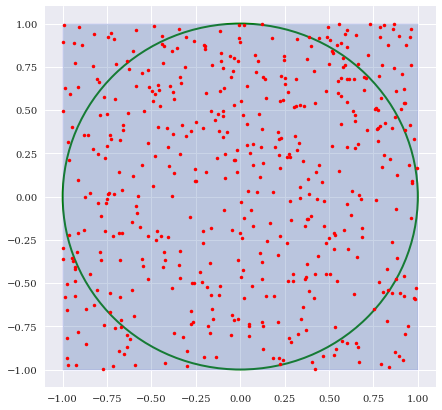

In [0]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
circ = plt.Circle((0,0),radius=1,edgecolor='g',lw=2.0,facecolor='None')
box = plt.Rectangle((-1,-1),2,2,edgecolor='b',alpha=0.3)
ax.add_patch(circ)
ax.add_patch(box)
plt.plot(rn[:,0],rn[:,1],'r.')
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)

> A **NumPy** implementation of this algorithm is rather concise but also memory-intensive. Total execution time given the parameterization is about one second.

In [0]:
n = int(1e7)

In [0]:
%time rn = np.random.random((n,2)) * 2 - 1

CPU times: user 202 ms, sys: 165 ms, total: 368 ms
Wall time: 370 ms


In [0]:
rn.nbytes

160000000

In [0]:
%time distance = np.sqrt((rn**2).sum(axis=1))
distance[:8].round(3)

CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 194 ms


array([0.162, 0.752, 0.388, 0.921, 0.865, 0.891, 0.844, 0.586])

In [0]:
%time frac = (distance <= 1.0).sum() / len(distance)

CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 24.2 ms


In [0]:
pi_mcs = frac * 4

In [0]:
pi_mcs

3.1421444

In [0]:
def mcs_pi_py(n):
  circle = 0
  for _ in range(n):
    x,y = random.random(), random.random()
    if (x**2+y**2)**0.5 <= 1:
      circle += 1
  return (4*circle)/n

In [0]:
%time mcs_pi_py(n)

CPU times: user 4.87 s, sys: 1.48 ms, total: 4.87 s
Wall time: 4.88 s


3.1424092

In [0]:
mcs_pi_nb = numba.jit(mcs_pi_py)

In [0]:
%time mcs_pi_nb(n)

CPU times: user 346 ms, sys: 6.97 ms, total: 353 ms
Wall time: 360 ms


3.1414204

In [0]:
%time mcs_pi_nb(n)

CPU times: user 149 ms, sys: 0 ns, total: 149 ms
Wall time: 149 ms


3.1421232

In [0]:
%%cython
import random
def mcs_pi_cy1(int n):
  cdef int i, circle = 0
  cdef float x,y
  for i in range(n):
    x,y = random.random(), random.random()
    if (x**2+y**2)**0.5 <= 1:
      circle += 1
  return (4*circle)/n

In [0]:
%time mcs_pi_cy1(n)

CPU times: user 1.81 s, sys: 5.83 ms, total: 1.81 s
Wall time: 1.81 s


3.1406364

In [0]:
%%cython
from libc.stdlib cimport rand
cdef extern from 'limits.h':
  int INT_MAX
def mcs_pi_cy2(int n):
  cdef int i, circle = 0
  cdef float x,y
  for i in range(n):
    x,y = rand()/INT_MAX, rand()/INT_MAX
    if (x**2+y**2)**0.5 <= 1:
      circle += 1
  return (4*circle)/n

In [0]:
%time mcs_pi_cy2(n)

CPU times: user 1.13 s, sys: 4.84 ms, total: 1.13 s
Wall time: 1.14 s


3.141952

# **Binomial Trees**

> A popular numerical method to value options is the binomial option pricing model pioneered by Cox, Ross, and Rubinstein. This method relies on representing the possible future evolution of an *asset* by a (recombining) tree. In this model, as in the Black-Scholes-Merton setup, there is a *risky asset*, an index or stock, and *riskless asset*, a bond. The relevant time interval from today until the maturity of the option is divided in general into equidistant subintervals of length $\Delta t$. Given an index level at time $s$ of $S_s$, the index level at $t=s + \Delta t$ is given by $S_t = S_s . m$, where $m$ is choose randomly from $\{u,d\}$ with $o < d < e^{r \Delta t} < u = e^{\sigma \sqrt{\Delta t}}$ as well as $u = \frac{1}{d} . r$ is the constant, riskless short rate.

> ## **Python**

In [0]:
S0 = 36. # initial value of the risky asset
T = 1.0 # Time horizon for the binomial tree simulation
r = 0.06 # Constant short rate
sigma = 0.2 # Constant volatility factor

In [0]:
def simulate_tree(M):
  dt = T/M # Length of the time intervals
  u = math.exp(sigma*math.sqrt(dt)) # Factors for the upward and downward movements.
  d = 1 / u
  S = np.zeros((M+1,M+1))
  S[0,0] = S0
  z = 1
  for t in range(1, M+1):
    for i in range(z):
      S[i,t] = S[i,t-1] * u
      S[i+1,t] = S[i,t-1] * d
    z += 1
  return S

Contrary to what happens in typical tree plots, an upward movement is represented in the **ndarray** object as a sideways movement, which decreases the **ndarray** size considerably

In [0]:
np.set_printoptions(formatter={'float':lambda x: '%6.2f' % x})

In [6]:
simulate_tree(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [7]:
%time simulate_tree(500)

CPU times: user 129 ms, sys: 1.64 ms, total: 131 ms
Wall time: 134 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

## **NumPy**

> With some trickery, such a binomial tree can be created with **NumPy** based on fully vectorized code.

In [0]:
M = 4

In [20]:
up = np.arange(M+1)
up

array([0, 1, 2, 3, 4])

In [22]:
up = np.resize(up,(M+1,M+1)) # ndarray object with gross upward movements
up

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [25]:
down = up.T * 2 # ndarray object with gross downward movements (up.T is transpose)
down

array([[0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2],
       [4, 4, 4, 4, 4],
       [6, 6, 6, 6, 6],
       [8, 8, 8, 8, 8]])

In [27]:
up - down # object with net upward (positive) and downward (negative) movements

array([[ 0,  1,  2,  3,  4],
       [-2, -1,  0,  1,  2],
       [-4, -3, -2, -1,  0],
       [-6, -5, -4, -3, -2],
       [-8, -7, -6, -5, -4]])

In [0]:
dt = T/M

In [29]:
S0*np.exp(sigma * math.sqrt(dt)*(up-down))

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In [0]:
def simulate_tree_np(M):
  dt = T/M
  up = np.arange(M+1)
  up = np.resize(up,(M+1,M+1)) 
  down = up.transpose() * 2
  s = S0*np.exp(sigma * math.sqrt(dt)*(up-down))
  return s

In [31]:
simulate_tree_np(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In [42]:
%time simulate_tree_np(500)

CPU times: user 9.96 ms, sys: 1.21 ms, total: 11.2 ms
Wall time: 14.6 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [ 35.36,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [ 34.73,  35.05,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.41,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.40,   0.41,   0.41]])

## **Numba**

> This financial algorithm should be well suited to optimization through **Numba** dynamic compilation. And indeed, another speedup compared to the **NumPy** version of an order of magnitude is observed. This makes the **Numba** version orders of magnitude faster than the python

In [0]:
simulate_tree_nb = numba.jit(simulate_tree)

In [34]:
simulate_tree_nb(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [41]:
%time simulate_tree_nb(500)

CPU times: user 906 µs, sys: 0 ns, total: 906 µs
Wall time: 917 µs


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

## **Cython**

> As before, **Cython** requires more adjustments to the code to see significant improvements. The following version uses mainly static type declarations and certain imports that improve the performance comapred to the regular python imports and functions, respectively.

In [50]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [0]:
%%cython
import numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0= 63.
cdef float T = 1.0 
cdef float r = 0.06 
cdef float sigma = 0.2 
def simulate_tree_cy(int M):
  cdef int z, t, i
  cdef float dt, u, d
  cdef float[:,:] S = np.zeros((M+1,M+1),dtype=np.float32)
  dt = T/M 
  u = exp(sigma * sqrt(dt))
  d = 1 / u
  S[0,0] = S0
  z = 1
  for t in range(1, M+1):
    for i in range(z):
      S[i,t] = S[i,t-1] * u
      S[i+1,t] = S[i,t-1] * d
    z += 1
  return np.array(S)

In [52]:
simulate_tree_cy(4)

array([[ 63.00,  69.63,  76.95,  85.04,  93.98],
       [  0.00,  57.00,  63.00,  69.63,  76.95],
       [  0.00,   0.00,  51.58,  57.00,  63.00],
       [  0.00,   0.00,   0.00,  46.67,  51.58],
       [  0.00,   0.00,   0.00,   0.00,  42.23]], dtype=float32)

In [56]:
%time simulate_tree_cy(500)

CPU times: user 0 ns, sys: 1.97 ms, total: 1.97 ms
Wall time: 1.29 ms


array([[ 63.00,  63.57,  64.14, ..., 5417.60, 5466.28, 5515.39],
       [  0.00,  62.44,  63.00, ..., 5321.55, 5369.36, 5417.60],
       [  0.00,   0.00,  61.88, ..., 5227.20, 5274.17, 5321.55],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.73,   0.74,   0.75],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.73,   0.73],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.72]],
      dtype=float32)

In [55]:
%timeit S= simulate_tree_cy(500)

1000 loops, best of 3: 615 µs per loop


# **Monte Carlo Simulation**

> Monte Carlo simulation is an indispensable numerical tool in comutational finance. It has been in use since long before the advent of modern computers. Banks and other financial institutions use it, among others, for **pricing and risk management** purposes. As a numerical method it is perhaps, the most flexible and powerful one in finance. However, it often also is the most computationally demanding one. That is why python was long dismissed as proper programming language to implement algorithms based on Monte carlo simulation - at ;east for real-world application scenarios. This section analyzes the monte carlo simulation of the geometric Brownian motion, a simple yet still widely used stochastic process to model the evolution of stock prices or index levels. Among others, the Black-Scholes-Merton theory of option pricing draws on this process. In their setup the underlying of the option to be valued follows the stochastic differential equation(SDE). $S_t$ is the value of the underlying at time $t;r$ is the constant, riskless short rate: $\sigma$ is the constant instantaneous volatiltiy; and $Z_t$ is Brownian motion. equation of **Black-Scholes_Merton SDE(geometric Brownian motion) Equation 1**

**$dS_t=rS_t dt+ \sigma S_tdZ_t$**

> This SDE can be discretized over quidistant time intervals and simulated according to below equation which represents and **Euler Scheme**. In this case, z is a standard normally distributed random number. For M time intervals, the length of the time interval is given as $\Delta t \equiv \frac{T}{M}$ where T is the time horizon for the simulation
**Black-Scholes_Merton difference equation(Euler scheme) Equation 2**

**$S_t = S_{t-\Delta t} exp((r- \frac{\sigma^2}{2})\Delta t+\sigma\sqrt{\Delta t z}$**

> The Monte Carlo estimator for a European call option is then given by below equation where $S_T(i)$ is the ith simulated value of the underlying at maturity T for a total number of simulated paths I with i = 1,2,....I.
** Monte Carlo estimator for a European call option Equation 3**

$C_0 = e^{-rT}\frac{1}{I} \displaystyle \sum_I max(S_T(i)-K,0)$



## **Python**

> `mcs_simulation_py()`, that implements the monte carlo simulation according to **equation 2**. It is hybrid since it implements python loops on **ndarray** objects. As seen previously, this might make for a good basis to dynamically compile the code with **Numba**. As before, the execution time sets the benchmark. Based on the simulation, a European put option is valued.

In [0]:
M = 100
I = 50000
s0 = 36.
def mcs_simulation_py(p):
  M, I = p
  dt = T/M
  S = np.zeros((M+1,I))
  S[0] = S0
  rn = np.random.standard_normal(S.shape)
  for t in range(1,M+1):
    for i in range(I):
      S[t,i] = S[t-1,i]*math.exp((r-sigma ** 2/2)*dt+sigma*math.sqrt(dt)*rn[t,i])
  return S

In [60]:
%time S = mcs_simulation_py((M,I))

CPU times: user 6.71 s, sys: 0 ns, total: 6.71 s
Wall time: 6.72 s


In [62]:
S[-1].mean()

38.23369289642214

In [63]:
S0 * math.exp(r*T)

38.22611567563295

In [0]:
K = 40.

In [0]:
C0 = math.exp(-r*T)*np.maximum(K-S[-1],0).mean()

In [67]:
C0

3.836405238617296

## **NumPy**

In [0]:
def mcs_simulation_np(p):
  M, I = p
  dt = T/M
  S = np.zeros((M+1,I))
  S[0] = S0
  rn = np.random.standard_normal(S.shape)
  for t in range(1,M+1):
    S[t] = S[t-1]*np.exp((r-sigma ** 2/2)*dt+sigma*math.sqrt(dt)*rn[t])
  return S

In [69]:
%time S = mcs_simulation_np((M,I))

CPU times: user 358 ms, sys: 0 ns, total: 358 ms
Wall time: 364 ms


In [70]:
S[-1].mean()

38.21680195071824

In [71]:
%timeit S = mcs_simulation_np((M,I))

1 loop, best of 3: 349 ms per loop


## **Numba**

In [0]:
mcs_simulation_nb = numba.jit(mcs_simulation_py)

In [75]:
%time S = mcs_simulation_np((M,I))

CPU times: user 358 ms, sys: 1.87 ms, total: 359 ms
Wall time: 362 ms


In [76]:
S[-1].mean()

38.170621156549515

In [77]:
%timeit S = mcs_simulation_np((M,I))

1 loop, best of 3: 350 ms per loop


## **Cython**

In [0]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0= 63.
cdef float T = 1.0 
cdef float r = 0.06 
cdef float sigma = 0.2 
@cython.boundscheck(False)
@cython.wraparound(False)
def mcs_simulation_cy(p):
  cdef int M,I
  M, I = p
  cdef int t,i
  cdef float dt = T/M
  cdef double[:,:] S = np.zeros((M+1,I))
  cdef double[:,:] rn = np.random.standard_normal((M+1,I))
  for t in range(1,M+1):
    for i in range(I):
      S[t,i] = S[t-1,i]*exp((r-sigma ** 2/2)*dt+sigma*sqrt(dt)*rn[t,i])
  return np.array(S)

In [80]:
%time S = mcs_simulation_cy((M,I))

CPU times: user 342 ms, sys: 1.85 ms, total: 344 ms
Wall time: 348 ms


In [81]:
%timeit S = mcs_simulation_cy((M,I))

1 loop, best of 3: 340 ms per loop


## **Multiprocessing**

In [0]:
pool = mp.Pool(processes=4)

In [0]:
p = 20

In [85]:
%timeit S = np.hstack(pool.map(mcs_simulation_np,p*[(M,int(I/p))]))

1 loop, best of 3: 315 ms per loop


In [86]:
%timeit S = np.hstack(pool.map(mcs_simulation_nb,p*[(M,int(I/p))]))

The slowest run took 5.20 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 336 ms per loop


In [87]:
%timeit S = np.hstack(pool.map(mcs_simulation_cy,p*[(M,int(I/p))]))

1 loop, best of 3: 303 ms per loop


# **Recursive pandas Algorithm**

> While **pandas** allows for sophisticated vectorized operations on **DataFrame** objects, certain recursive algorithm are hard or impossible to vectorize, leaving the financial analyst with slowly executed python loops on **DataFrame** objects. The example that follow implement what is called the *exponentially weighted moving average (EWMA) in a simple form.
**Exponentially weightedmoving average (EWMA)**

$EWMA_0 = S_0$
$EWMA_t = \alpha . S_t + (1-\alpha).EWMA_{t-1}, t \in {1,....T}$

> Although simple in nature and straightforward to implement, such an algorithm might lead to rather slow code.

## **Python**

In [0]:
sym = 'SPY'
data = pd.DataFrame(pd.read_csv(files_path+'tr_eikon_eod_data.csv',index_col=0,parse_dates=True)[sym]).dropna()

In [0]:
alpha = 0.25

In [0]:
data['EWMA'] = data[sym]

In [93]:
%%time
for t in zip(data.index,data.index[1:]):
  data.loc[t[1],'EWMA'] = (alpha*data.loc[t[1],sym]+(1-alpha)*data.loc[t[0],'EWMA'])

CPU times: user 709 ms, sys: 26 ms, total: 735 ms
Wall time: 692 ms


In [94]:
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


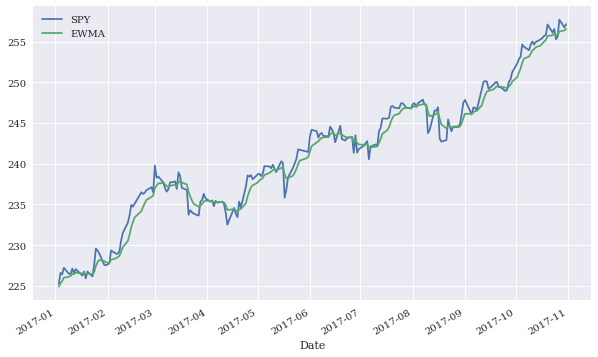

In [95]:
data[data.index > '2017-1-1'].plot(figsize=(10,6))

In [0]:
def ewma_py(x,alpha):
  y = np.zeros_like(x)
  y[0] = x[0]
  for i in range(1,len(x)):
    y[i] = alpha * x[i] + (1-alpha)*y[i-1]
  return y

In [99]:
%time data['EMWA_PY'] = ewma_py(data[sym],alpha)

CPU times: user 44.2 ms, sys: 1.81 ms, total: 46 ms
Wall time: 49.1 ms


In [100]:
%time data['EMWA_PY'] = ewma_py(data[sym].values,alpha)

CPU times: user 3.32 ms, sys: 0 ns, total: 3.32 ms
Wall time: 3.51 ms


## **Numba**

In [0]:
ewma_nb = numba.jit(ewma_py)

In [103]:
%time data['EMWA_NB'] = ewma_py(data[sym],alpha)

CPU times: user 43 ms, sys: 1.08 ms, total: 44.1 ms
Wall time: 44.2 ms


In [104]:
%timeit data['EMWA_NB'] = ewma_py(data[sym],alpha)

10 loops, best of 3: 36.2 ms per loop


In [108]:
%time data['EMWA_NB'] = ewma_py(data[sym].values,alpha)

CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 1.94 ms


In [107]:
%timeit data['EMWA_NB'] = ewma_py(data[sym].values,alpha)

1000 loops, best of 3: 1.58 ms per loop


## **Cython**

In [0]:
%%cython
import numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def ewma_cy(double[:] x,float alpha):
  cdef int i
  cdef double[:] y  = np.empty_like(x)
  y[0] = x[0]
  for i in range(1,len(x)):
    y[i] = alpha * x[i] + (1-alpha)*y[i-1]
  return y

In [110]:
%time data['EMWA_CY'] = ewma_py(data[sym].values,alpha)

CPU times: user 5.05 ms, sys: 1 µs, total: 5.05 ms
Wall time: 5.43 ms


In [111]:
%timeit data['EMWA_CY'] = ewma_py(data[sym].values,alpha)

1000 loops, best of 3: 1.63 ms per loop
